In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_mll_torch
import sobol_seq
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement, qLogNoisyExpectedHypervolumeImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.generation.gen import gen_candidates_torch
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import LinearKernel, RBFKernel, MaternKernel, ScaleKernel, RQKernel
from gpytorch.means import ConstantMean
from pyRheo.oscillation_evaluator import SAOSEvaluator
from pyRheo.relaxation_evaluator import RelaxationEvaluator
from gpytorch.constraints import Interval

import scienceplots
plt.style.use(['science', 'nature', 'retro'])

# Error function
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Load oscillation data
data1 = pd.read_csv('./data/polystyrene/master_curve_ps_oscillation_data.csv', delimiter=',', decimal=".")
# Filter data for omega < 10
data1 = data1[data1['Angular Frequency'] < 10]
omega = data1['Angular Frequency'].values
G_prime = data1['Storage Modulus'].values
G_double_prime = data1['Loss Modulus'].values

data2 = pd.read_csv('./data/polystyrene/master_curve_ps_relaxation_data.csv', delimiter=',', decimal=".")
# Filter data for time > 0.02
data2 = data2[data2['Time'] > 0.05]
data2 = data2[data2['Time'] < 500]

time = data2['Time'].values
G_relax = data2['Relaxation Modulus'].values

# Objective function to minimize (RRS weighted by true values) - two objectives
def objective(params):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalMaxwell"
    
    # Compute oscillation data
    evaluator1 = SAOSEvaluator(model=model)
    model_values1 = evaluator1.compute_model(params_no_scale, omega) 
    error1 = createRandomError(omega.shape[0], 0.00)
    model_values_noisy1 = np.multiply(model_values1, error1)

    # Compute relaxation data
    evaluator2 = RelaxationEvaluator(model=model)
    model_values2 = evaluator2.compute_model(params_no_scale, time, mittag_leffler_type="Pade72") 
    error2 = createRandomError(time.shape[0], 0.00)
    model_values_noisy2 = np.multiply(model_values2, error2)
    
    # Define objective functions
    obj1 = np.sum(((G_prime - model_values_noisy1[0]) / G_prime) ** 2) + np.sum(((G_double_prime - model_values_noisy1[1]) / G_double_prime) ** 2)
    obj2 = np.sum(((G_relax - model_values_noisy2) / G_relax) ** 2)
    return np.array([-np.log10(obj1), -np.log10(obj2)])

# Define search space bounds
param_space = np.array([
    [2, 6],  # log10 scale for G
    [4, 7],  # log10 scale for V
    [0.5, 0.99],   # real scale for alpha
    [0, 0.4],   # real scale for beta
])

# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)

# Initialize model function for multi-objective problem
def initialize_model(train_x, train_obj):
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
        models.append(SingleTaskGP(train_x, train_y, covar_module=ScaleKernel(MaternKernel(nu=1.5,
                                                   ard_num_dims=4,
                                                   lengthscale_constraint=Interval(0.01, 10)), 
                                                    outcome_transform=None, 
                                                    train_Yvar=None)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# Compute the qEHVI acquisition function to find new candidate points that maximize objectives
def compute_qehvi_acquisition_function(model, train_x, train_obj, bounds):
    ref_point = torch.max(train_obj, dim=0)[0] # Ensure it is a tensor
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=train_obj)
    acq_func = qLogExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),  # Convert only when necessary
        partitioning=partitioning
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=2,
        raw_samples=50,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

# Initial sampling using Sobol sequence
n_initial_points = 8
X_samples = sobol_sample(param_space, n_initial_points)
y_samples = np.array([objective(x) for x in X_samples])


# Convert to tensors for BoTorch
X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
y_samples_tensor = torch.tensor(y_samples, dtype=torch.double)

# Compute bounds for optimization
bounds = torch.stack([
    torch.tensor(param_space[:, 0], dtype=torch.double),
    torch.tensor(param_space[:, 1], dtype=torch.double)
])

# Initialize and fit the GP model
mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
fit_gpytorch_mll(mll, options={"maxiter": 20})

/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9811], dtype=torch.float64), mean = tensor([-2.5413], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.8936], dtype=torch.float64), mean = tensor([-4.2341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (raw_lengthscale_constraint): Interval(1.000E-02, 1.000E+01)
          )
          (raw_outputscale_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x GaussianLikelihood(
          (noise_covar): HomoskedasticN

In [2]:
import warnings
from botorch.models.utils.assorted import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

# Exploitation phase using qEHVI
n_exploitation_iter = 200 # Number of iterations
objective_list = []
new_indices = []  # To keep track of new points added during exploitation
objective_values = list(y_samples)

# Stop condition parameters
no_improvement_limit = 200  # Stop if no improvement after 50 iterations
no_improvement_counter = 0
best_objective_value = float('inf')  # Assuming we're minimizing
tolerance = 1e-4  # Minimum improvement required to reset the counter

for i in range(n_exploitation_iter):
    torch.manual_seed(42)
    np.random.seed(42)
    
    new_candidates = compute_qehvi_acquisition_function(model, X_samples_tensor, y_samples_tensor, bounds)
    new_sample = new_candidates.detach().cpu().numpy().reshape(-1)
    new_sample_y = objective(new_sample)
    
    # Append the new sample to the samples and objective values
    new_indices.append(len(y_samples))  # Save the index of the new sample
    X_samples = np.vstack([X_samples, new_sample])
    y_samples = np.vstack([y_samples, new_sample_y])
    
    # Update tensors
    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
    y_samples_tensor = torch.tensor(y_samples, dtype=torch.double)

    # Append the objective value to the list (original scale)
    objective_list.append(new_sample_y)
    objective_values.append(new_sample_y)
    
    # Update the model with the new data
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    fit_gpytorch_mll(mll, options={"maxiter": 20})
    
    print(f"Exploitation {i + 1}/{n_exploitation_iter} - New sample: {new_sample}, Objective values: {new_sample_y}")

    # Check stop condition based on no improvement with tolerance
    new_sample_y_sum = new_sample_y[0] + new_sample_y[1]    
    improvement = best_objective_value - new_sample_y_sum
    if improvement > tolerance:
        best_objective_value = new_sample_y_sum
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= no_improvement_limit:
        print(f"Stopping early due to no significant improvement (>{tolerance}) in the last {no_improvement_limit} iterations.")
        break

Exploitation 1/200 - New sample: [6.   4.   0.99 0.4 ], Objective values: [-2.21563695 -4.02153556]
Exploitation 2/200 - New sample: [2.  4.  0.5 0. ], Objective values: [-2.28235278 -4.01059127]
Exploitation 3/200 - New sample: [4.35072832 4.95309633 0.5        0.4       ], Objective values: [-2.12350897 -3.73752584]
Exploitation 4/200 - New sample: [2.  7.  0.5 0.4], Objective values: [-2.29050889 -4.02121647]
Exploitation 5/200 - New sample: [5.10243807 4.         0.99       0.4       ], Objective values: [-2.20600518 -4.01814416]
Exploitation 6/200 - New sample: [4.44610118 4.87636161 0.99       0.        ], Objective values: [-2.15652567 -3.90637814]
Exploitation 7/200 - New sample: [5.43628207 4.52221867 0.5        0.4       ], Objective values: [-1.99417331 -3.64471301]
Exploitation 8/200 - New sample: [6.         4.59805318 0.5        0.        ], Objective values: [-1.99454988 -3.55821916]
Exploitation 9/200 - New sample: [5.87600334 4.77685804 0.5        0.4       ], Objectiv

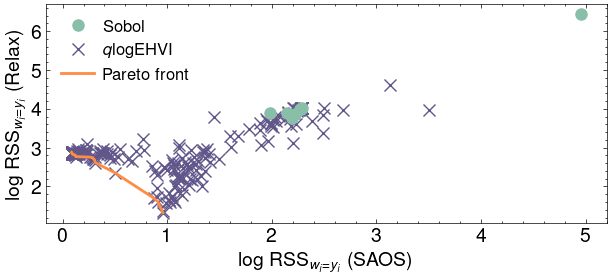

Best parameters from Bayesian Optimization: G = 76004.62, V = 703763.07, alpha = 0.90, beta = 0.26


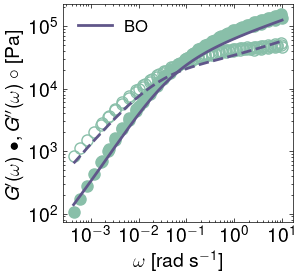

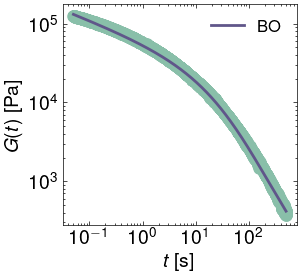

In [3]:
# Highlight new points
new_points_mask = np.zeros(len(y_samples), dtype=bool)
new_points_mask[new_indices] = True

# Identify the final Pareto front points
pareto_mask = is_non_dominated(y_samples_tensor)
pareto_front = y_samples[pareto_mask]

# Convert to NumPy for easy sorting
x = -pareto_front[:, 0]
y = -pareto_front[:, 1]

# Sort by x values (ascending order)
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Error function
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Define the Fractional Maxwell Liquid model (springpot-dashpot)
plt.figure(figsize=(6.1, 2.75), constrained_layout=True)
plt.plot(-y_samples[new_points_mask][:, 0], -y_samples[new_points_mask][:, 1], "x", markersize=8, label='$q$logEHVI', color='#60568A')
plt.plot(-y_samples[~new_points_mask][:, 0], -y_samples[~new_points_mask][:, 1], "o", markersize=8, label='Sobol', color='#89BFA9')
#plt.plot(-pareto_front[:, 0], -pareto_front[:, 1], "-", markersize=8, color="#FF8C42", label='pareto front')
plt.plot(x_sorted, y_sorted, "-",  color="#FF8C42", lw=2, label='Pareto front')
plt.xlabel('$\\log$ RSS$_{w_{i} = y_{i}}$ (SAOS)', fontsize=14)
plt.ylabel('$\\log$ RSS$_{w_{i} = y_{i}}$ (Relax)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12, loc="best", handletextpad=0.0)  # Adjust handletextpad as needed
# Get current legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder: put 'Sobol' in the second position
order = [1, 0, 2]  # 0 = 'Sobol', 1 = 'qEHVI'

# Apply the new order
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12, loc="best", handletextpad=0.5)

plt.savefig("fig_qehvi_multioutput.pdf")
plt.show()

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(y_samples[:, 0] + y_samples[:, 1])
best_params = X_samples[best_idx]
logG_best, logV_best, alpha_best, beta_best = best_params
G_best_bo = 10 ** logG_best
V_best_bo = 10 ** logV_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.2f}, V = {:.2f}, alpha = {:.2f}, beta = {:.2f}".format(G_best_bo, V_best_bo, alpha_best, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
# Define model evaluator
fractional_model_name = "FractionalMaxwell"
evaluator1 = SAOSEvaluator(model=fractional_model_name)
evaluator2 = RelaxationEvaluator(model=fractional_model_name)

best_params_no_scale = G_best_bo, V_best_bo, alpha_best, beta_best
bo_model_values1 = evaluator1.compute_model(best_params_no_scale, omega)
bo_model_values2 = evaluator2.compute_model(best_params_no_scale, time, mittag_leffler_type="Pade72")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9')
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8)
plt.plot(omega, bo_model_values1[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values1[1], '--', color='#60568A', lw=2)

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("fig_qehvi_multioutput_fit_saos.pdf")
plt.show()

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(time, G_relax, 'o', markersize=8, color='#89BFA9')
plt.plot(time, bo_model_values2, '-', color='#60568A', lw=2, label='BO')

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("fig_qehvi_multioutput_fit_relax.pdf")
plt.show()

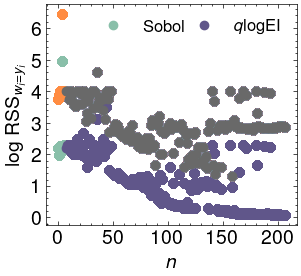

In [4]:
# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Iterate over results from each run and plot
for idx, res in enumerate(y_samples):
    objective_values1 = y_samples[:,0]
    objective_values2 = y_samples[:,1]
    iterations = np.arange(len(y_samples))
    neg_objective_values1 = -np.array(objective_values1)
    neg_objective_values2 = -np.array(objective_values2)


    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values1[:n_initial_points],
        'o', 
        markersize=6, 
        label='Sobol' if idx == 0 else "",  # Label only the first run
        color='#89BFA9'
    )

    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values2[:n_initial_points],
        'o',
        markersize=6, 
        color="#FF8C42",
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values1[n_initial_points:], 
        "o",
        markersize=6,
        label='$q$logEI' if idx == 0 else "", 
        color='#60568A'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values2[n_initial_points:], 
        "o",
        markersize=6
    )



# Customize Plot Appearance
#plt.xlim(0, 110)                                          # Set x-axis limit
#plt.ylim(-1, 3.8)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=12, loc="upper right", ncols=2, columnspacing=0.1, 
           #bbox_to_anchor=(1.05, 1)
          )                       # Display legend

# Display the Plot
plt.savefig("fig_qlogEHVI_path.pdf")                    # Uncomment to save the plot
plt.show()

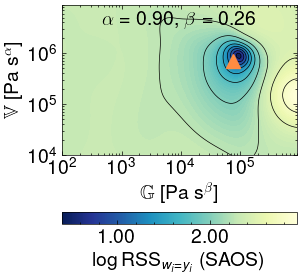

In [10]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.models[0].posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [(alpha_best, beta_best)]
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj1_mean = predict_model_mean_on_grid_2D(model, param_space, alpha_best, beta_best, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj1_mean), -np.min(preds_obj1_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj1_mean = -1 * preds_obj1_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj1_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj1_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 900000)
plt.ylim(10000, 9000000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$ (SAOS)', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_SAOS.pdf")
plt.show()

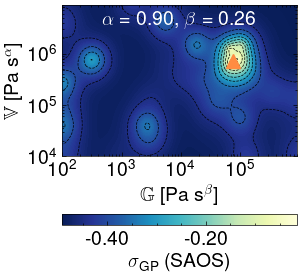

In [6]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.models[0].posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [
(0.87, 0.23),
]
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj1_mean = predict_model_mean_on_grid_2D(model, param_space, alpha_best, beta_best, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj1_mean), -np.min(preds_obj1_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj1_mean = -1 * preds_obj1_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj1_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj1_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 900000)
plt.ylim(10000, 9000000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$',
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$ (SAOS)', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_std_SAOS.pdf")
plt.show()

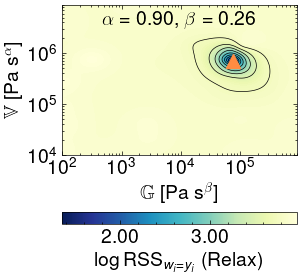

In [7]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.models[1].posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [
(0.87, 0.23),
]
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj1_mean = predict_model_mean_on_grid_2D(model, param_space, alpha_best, beta_best, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj1_mean), -np.min(preds_obj1_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj1_mean = -1 * preds_obj1_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj1_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj1_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 900000)
plt.ylim(10000, 9000000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$',
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$  (Relax)', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_relax.pdf")
plt.show()

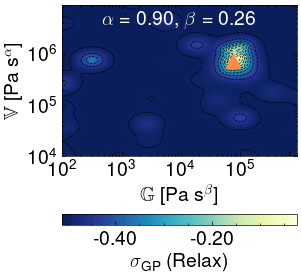

In [8]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.models[1].posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [
(0.87, 0.23),
]
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj1_mean = predict_model_mean_on_grid_2D(model, param_space, alpha_best, beta_best, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj1_mean), -np.min(preds_obj1_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj1_mean = -1 * preds_obj1_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj1_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj1_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 900000)
plt.ylim(10000, 9000000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$ (Relax)', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_std_relax.pdf")
plt.show()